<a href="https://colab.research.google.com/github/finlaycm/tensorflow_tumor_detection/blob/master/part3_the_model_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
colab_root_dir = '/content'
drive_dir='/content/drive'
project_root_dir = os.path.join(drive_dir,'My Drive','deeplearning','cancer_classification')
drive.mount(drive_dir)
data_dir = os.path.join(project_root_dir,'data')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains all the slides and tumor masks I converted (and these should be *plenty* for your project). If you'd like more beyond this, you'll need to use ASAP as described on the competition website to convert it into an appropriate format. 

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system). Happy to help in OH if you're stuck.

### Reminder

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), or use all the available data. 


In [ ]:
#Install the OpenSlide C library and Python bindings
# !apt-get install openslide-tools
# !pip install openslide-python

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from skimage.color import rgb2gray
import cv2 as cv
import json
from google.colab import drive
import pathlib
import shutil
import random

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Flatten, Input, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

print(tf.__version__)


2.0.0


In [ ]:
shutil.copy(os.path.join(project_root_dir,'patches.zip'),colab_root_dir)
!unzip -q 'patches' -d "patches"

In [ ]:
train_dir = os.path.join('patches', 'train')
val_dir = os.path.join('patches', 'val')
test_dir = os.path.join('patches', 'test')
print('Total train negative images:', len(os.listdir(train_dir+'/negative')))
print('Total train positive images:', len(os.listdir(train_dir+'/positive')))
print('Total validation negative images:', len(os.listdir(val_dir+'/negative')))
print('Total validation positive images:', len(os.listdir(val_dir+'/positive')))
print('Total test negative images:', len(os.listdir(test_dir+'/negative')))
print('Total test positive images:', len(os.listdir(test_dir+'/positive')))


Total train negative images: 26868
Total train positive images: 36058
Total validation negative images: 6634
Total validation positive images: 9098
Total test negative images: 6328
Total test positive images: 8864


In [ ]:
def my_leaky_relu(x):
    return tf.nn.leaky_relu(x, alpha=0.01)
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       2

In [ ]:
model.compile(loss='binary_crossentropy',
optimizer='adam',
metrics=['acc'])

In [ ]:
os.remove('patches/train/positive/tumor_091_5_10273.jpg')
os.remove('patches/train/positive/tumor_110_19_34406.jpg')



In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
                  train_dir,
                  target_size=(128, 128),
                  batch_size=32,
                  shuffle=True,
                  class_mode='binary')
val_generator = val_datagen.flow_from_directory(
                  val_dir,
                  target_size=(128, 128),
                  batch_size=32,
                  class_mode='binary')
test_generator = test_datagen.flow_from_directory(
                  test_dir,
                  target_size=(128, 128),
                  batch_size=1,
                  class_mode='binary')

Found 62924 images belonging to 2 classes.
Found 15732 images belonging to 2 classes.
Found 15192 images belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_generator:
  print('data batch shape:', data_batch.shape)
  print('labels batch shape:', labels_batch.shape)
  break

data batch shape: (32, 128, 128, 3)
labels batch shape: (32,)


In [ ]:
history = model.fit_generator(
          train_generator,
          steps_per_epoch=1500,
          epochs=50,
          validation_data=val_generator,
          validation_steps=50
          )

Epoch 1/50
1500/1500 [==============================] - 96s 64ms/step - loss: 0.2982 - acc: 0.8820 - val_loss: 0.2852 - val_acc: 0.8825
Epoch 2/50
1500/1500 [==============================] - 93s 62ms/step - loss: 0.2363 - acc: 0.9057 - val_loss: 0.2371 - val_acc: 0.8988
Epoch 3/50
1500/1500 [==============================] - 93s 62ms/step - loss: 0.2157 - acc: 0.9156 - val_loss: 0.2027 - val_acc: 0.9187
Epoch 4/50
1500/1500 [==============================] - 93s 62ms/step - loss: 0.1913 - acc: 0.9259 - val_loss: 0.1895 - val_acc: 0.9250
Epoch 5/50
1500/1500 [==============================] - 93s 62ms/step - loss: 0.1799 - acc: 0.9321 - val_loss: 0.1953 - val_acc: 0.9225
Epoch 6/50
1500/1500 [==============================] - 93s 62ms/step - loss: 0.1742 - acc: 0.9342 - val_loss: 0.1938 - val_acc: 0.9250
Epoch 7/50
1500/1500 [==============================] - 93s 62ms/step - loss: 0.1668 - acc: 0.9385 - val_loss: 0.1823 - val_acc: 0.9275
Epoch 8/50
1500/1500 [==========================

In [ ]:
model.save(os.path.join(project_root_dir,'cancer6.h5'))

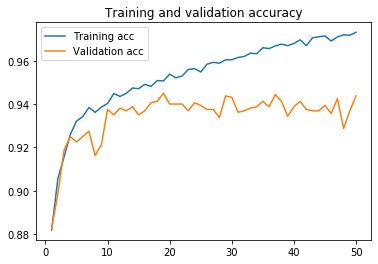

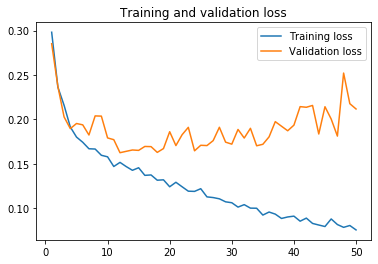

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()